In [2]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt

og_data = pd.read_csv('f1_data_og.csv')
cleaned_df = pd.read_csv('cleaned.csv')
cleaned_df


,Unnamed: 0,season,round,GP_circuit,grid,team_name,driver,driver_age,driver_wins,constructor_wins,pos_delta,driver_dnf_ratio,position
0,0,2009,1,Albert Park Grand Prix Circuit,1,Brawn,Jenson Button,29.0,1,1,0,0.072797,1
1,1,2009,1,Albert Park Grand Prix Circuit,2,Brawn,Rubens Barrichello,37.0,1,0,0,0.089623,2
2,2,2007,1,Albert Park Grand Prix Circuit,14,Honda,Jenson Button,27.0,0,0,0,0.072797,14
3,3,2007,1,Albert Park Grand Prix Circuit,16,Honda,Rubens Barrichello,35.0,0,0,-1,0.089623,17
4,4,2006,3,Albert Park Grand Prix Circuit,1,Honda,Jenson Button,26.0,0,0,0,0.072797,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9557,9557,2021,20,Losail International Circuit,18,Alfa Romeo,Antonio Giovinazzi,28.0,0,0,0,0.081967,18
9558,9558,2021,20,Losail International Circuit,19,Haas F1 Team,Mick Schumacher,23.0,0,0,0,0.069767,19
9559,9559,2021,20,Losail International Circuit,20,Haas F1 Team,Nikita Mazepin,23.0,0,0,0,0.136364,20
9560,9560,2021,20,Losail International Circuit,2,AlphaTauri,Pierre Gasly,26.0,0,0,-2,0.084034,4


In [3]:
#2023 Tracks for testing in our function that we will define soon
circuit_list = cleaned_df[cleaned_df.season == 2023].GP_circuit.unique()
list(circuit_list)


['Albert Park Grand Prix Circuit',
 'Bahrain International Circuit',
 'Circuit de Barcelona-Catalunya',
 'Circuit de Monaco',
 'Silverstone Circuit',
 'Hungaroring',
 'Circuit de Spa-Francorchamps',
 'Circuit Gilles Villeneuve',
 'Red Bull Ring',
 'Baku City Circuit',
 'Jeddah Corniche Circuit',
 'Miami International Autodrome']

## Cleaned Data Frame Dictionary

|Feature          |Definition                                             |
|:---------------:|:------------------------------------------------------|
|Season (int)           |The year in which the race takes place                |
|Round (int)            |The specific round in the season |    
|GP_circuit (str) | The circuit at which the race occurs|
|grid (int) | Starting position of each driver|
|team_name (str) | Constructor Name|
|driver (str) | The name of each driver|
|driver_age (int) | The age of each driver|
|driver_wins (int) | The number of wins a driver has in that season at time of race|
|constructor_wins (int) | The number of wins a team has at a specific point in the season|
|pos_delta (int) | How many positions gained or lost in a race|
|driver_dnf_ratio (float) | The ratio of unfinished races to total races entered|
|position (int) | Target Var - Place of finish for each driver|



In [4]:
cleaned_df = cleaned_df.rename(columns = {
    'driver_wins':'team_wins',
    'constructor_wins': 'driver_wins'
})

In [5]:
#V10 Engine Era is the reason for sectioning of more data to the year 2000 and onwards
cleaned_df = cleaned_df[cleaned_df.season >= 2000]

# Data Pre-Processing

## One-Hot encoding 

In [6]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 

# Step 1: Encode Categorical Features

# one-hot encoding for 'GP_circuit' and 'team_name':
cleaned_df = pd.get_dummies(cleaned_df, columns=['GP_circuit', 'team_name'])


## Data Splitting

In [7]:
#Train on data from 2000 - 2018
train_data = cleaned_df[(cleaned_df['season'] >= 2000) & (cleaned_df['season'] < 2019)]

#Validate on data from 2019-2022
validation_data = cleaned_df[(cleaned_df['season'] >= 2019) & (cleaned_df['season'] <= 2022)]

#Test on 2023 grand prix using a function we will define after model selection
test_data = cleaned_df[(cleaned_df['season'] == 2023)]

## Function for Splitting and Scaling data 

In [8]:
from sklearn.preprocessing import RobustScaler
def split_data(GP_circuit, train = train_data, val = validation_data, test = test_data):

    """
    GP_circuit = 'GP_circuit_circuit_name'
    """
    gp = GP_circuit

    train = train.loc[train[gp] == 1, :]
    val = val.loc[val[gp] == 1, :]
    test = test.loc[test[gp] == 1, :]

    #X split
    X_train = train.drop(['driver', 'position'], axis = 1)
    X_val = val.drop(['driver', 'position'], axis = 1)
    X_test = test.drop(['driver', 'position'], axis = 1)

    #y split
    y_train = train['position']
    y_val = val['position']
    y_test = test['position']

    scaler = RobustScaler()

    #Only fit on training data and transform on all
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test


# Model Building

Making this function dynamic in the sense that we can test our model on different 2023 GP's.


In our previous Jupyter Notebook, we established our model selection to be SVM and Logistic Regression based on CV and HT

In [9]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
def model(GP_circuit, model, test = test_data):
  """ GP_circuit = 'race_title' <-- get from 2023 race list
      model = 'SVM', 'Logistic Regression'

      --> first run split and scale func
      --> if statement for either log reg or svm
      --> get score for train, val and test
  """

  gp = "GP_circuit_" + GP_circuit

  X_train, X_val, X_test, y_train, y_val, y_test = split_data(gp)

  if model == 'SVM': 
    svm_mod = SVC(kernel='linear', C=10, random_state=42, probability= True)
    svm_mod.fit(X_train, y_train)
    train_score = svm_mod.score(X_train, y_train)
    val_score = svm_mod.score(X_val, y_val)
    test_score = svm_mod.score(X_test, y_test)

    print('SVM Train Score:', train_score)
    print('SVM Validation Score:', val_score)
    print('SVM Test Score:', test_score)

    #Predict probabilties for test
    probas = svm_mod.predict_proba(X_test)
    # probability of winning
    prob_winning = probas[:,1]

    # predictions
    drivers = test[test[gp] == 1].driver
    results = pd.Series(prob_winning, index=drivers)
    # print(results.sort_values(ascending=False))

    return train_score, val_score, test_score

  elif model == 'Logistic Regression':
    log_reg_mod = LogisticRegression(max_iter = 3000, C=100, penalty='l2')
    log_reg_mod.fit(X_train, y_train)
    train_score = log_reg_mod.score(X_train, y_train)
    val_score = log_reg_mod.score(X_val, y_val)
    test_score = log_reg_mod.score(X_test, y_test)


    print('Logistic Regression Train Score:', train_score)
    print('Logistic Regression Validation Score:', val_score)
    print('Logistic Regression Test Score:', test_score)

    #Predict probabilties for test
    probas = log_reg_mod.predict_proba(X_test)
    # probability of winning
    prob_winning = probas[:,1]

    # predictions
    drivers = test[test[gp] == 1].driver
    results = pd.Series(prob_winning, index=drivers)
    # print(results.sort_values(ascending=False))

    return train_score, val_score, test_score
  
  else:
    raise Exception("Please enter one of the following models: SVM or Logistic Regression")
        

  






## Model Testing and Input

SVM Train Score: 0.8104575163398693
SVM Validation Score: 0.375
SVM Test Score: 0.2
SVM Train Score: 0.8424657534246576
SVM Validation Score: 0.37
SVM Test Score: 0.3
SVM Train Score: 0.8200589970501475
SVM Validation Score: 0.4875
SVM Test Score: 0.3
SVM Train Score: 0.8407079646017699
SVM Validation Score: 0.4406779661016949
SVM Test Score: 0.5
SVM Train Score: 0.8705234159779615
SVM Validation Score: 0.42
SVM Test Score: 0.45
SVM Train Score: 0.8189910979228486
SVM Validation Score: 0.3625
SVM Test Score: 0.45
SVM Train Score: 0.8513513513513513
SVM Validation Score: 0.375
SVM Test Score: 0.4
SVM Train Score: 0.840625
SVM Validation Score: 0.35
SVM Test Score: 0.3
SVM Train Score: 0.9274193548387096
SVM Validation Score: 0.14166666666666666
SVM Test Score: 0.2
SVM Train Score: 0.9836065573770492
SVM Validation Score: 0.1
SVM Test Score: 0.05


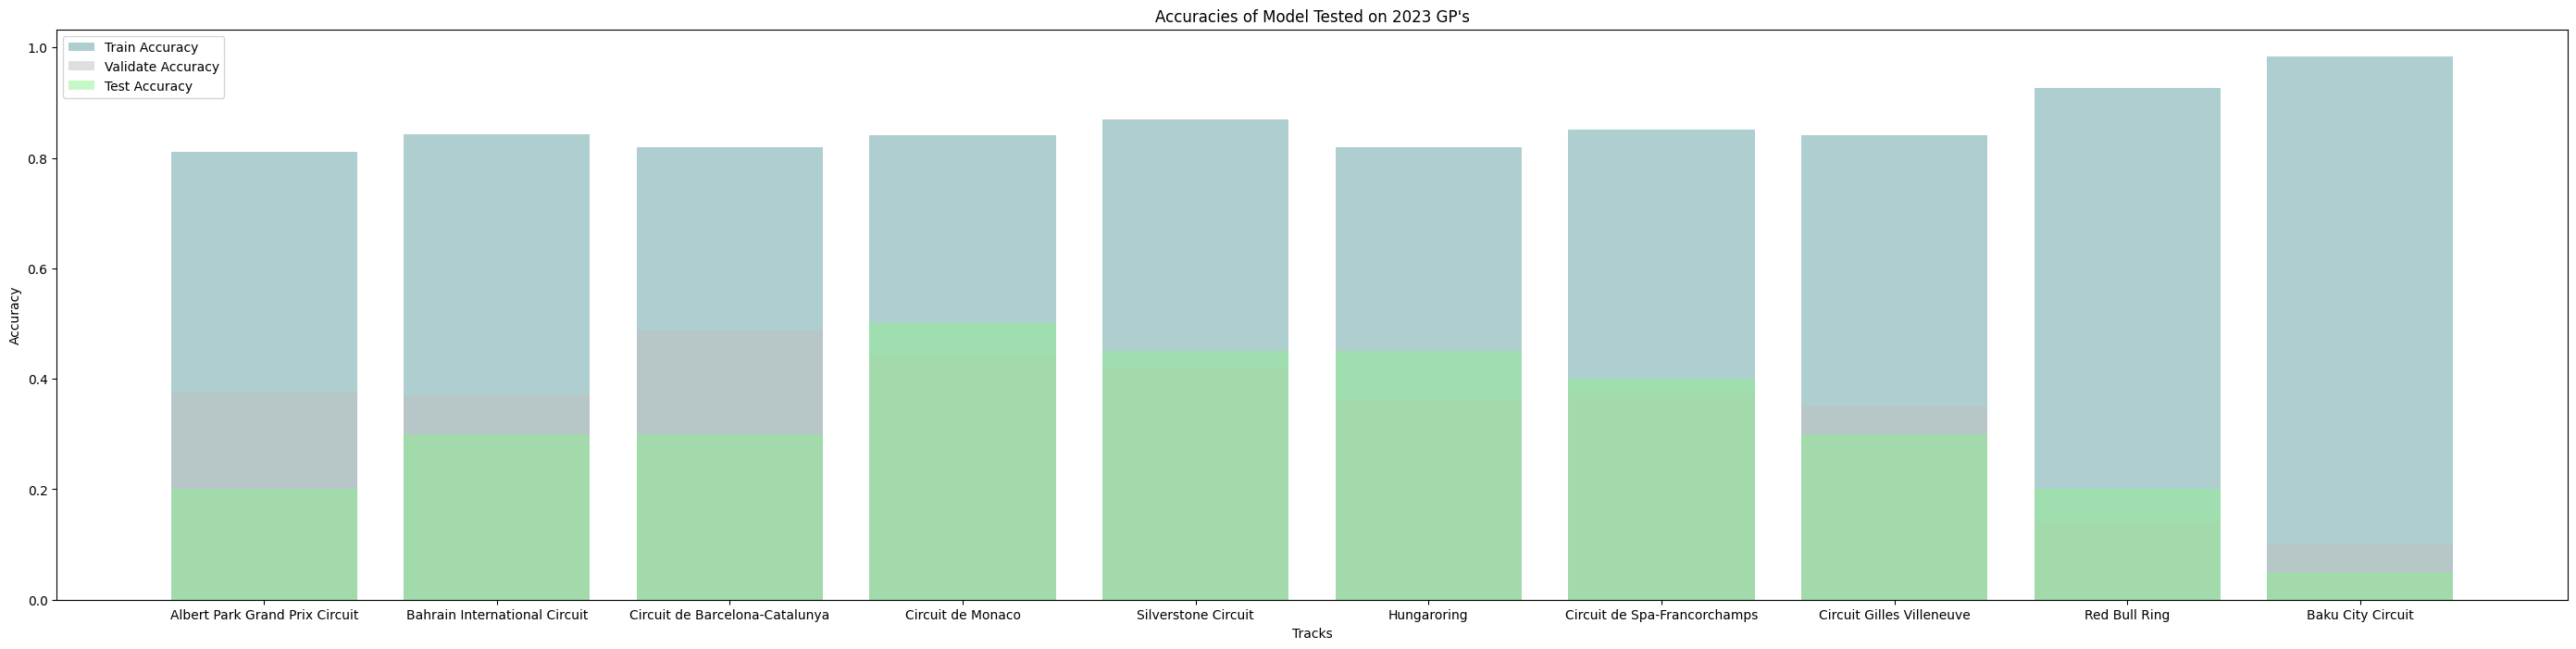

In [10]:
tracks = ['Albert Park Grand Prix Circuit',
 'Bahrain International Circuit',
 'Circuit de Barcelona-Catalunya',
 'Circuit de Monaco',
 'Silverstone Circuit',
 'Hungaroring',
 'Circuit de Spa-Francorchamps',
 'Circuit Gilles Villeneuve',
 'Red Bull Ring',
 'Baku City Circuit']

train_scores = []
val_scores = []
test_scores = []

for track in tracks:
    train_score, val_score, test_score = model(track, 'SVM')
    train_scores.append(train_score)
    val_scores.append(val_score)
    test_scores.append(test_score)

# Plot accuracies
plt.figure(figsize=(35, 8))
plt.bar([track for track in tracks], train_scores, alpha=0.5, label='Train Accuracy', color = 'cadetblue')
plt.bar([track for track in tracks], val_scores, alpha=0.5, label='Validate Accuracy', color = 'silver')
plt.bar([track for track in tracks], test_scores, alpha=0.5, label='Test Accuracy', color = 'lightgreen')
plt.xlabel('Tracks')
plt.ylabel('Accuracy')
plt.title("Accuracies of Model Tested on 2023 GP's")
plt.legend(loc='best')
plt.show()

